In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model


In [2]:
image_dir="../input/covid19-image-dataset/Covid19-dataset/train"

In [3]:
# TRAIN_PATH = '../input/covid19-image-dataset/Covid19-dataset/train'
# VAL_PATH = '../input/covid19-image-dataset/Covid19-dataset/test'

In [4]:
os.makedirs('../output/kaggle/working/augmented-images')
os.makedirs('../output/kaggle/working/augmented-images/Covid')
os.makedirs('../output/kaggle/working/augmented-images/Normal')

In [5]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [6]:
augmented_data_path ='../output/kaggle/working/augmented-images/'
# augment data for the examples with label equal to 'Covid' representing Covid examples
augment_data(file_dir=image_dir+'/Covid',n_generated_samples=2, save_to_dir=augmented_data_path+'Covid')
# augment data for the examples with label equal to 'Normal' representing Normal examples
augment_data(file_dir=image_dir+'/Normal', n_generated_samples=3, save_to_dir=augmented_data_path+'Normal')

In [7]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-5:] == 'Covid':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [8]:
covid_yes = '../input/covid19-image-dataset/Covid19-dataset/train/Covid'
covid_no = '../input/covid19-image-dataset/Covid19-dataset/train/Normal'

augmented_Covid ='../output/kaggle/working/augmented-images/Covid'
augmented_Normal ='../output/kaggle/working/augmented-images/Normal'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_Covid, augmented_Normal], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 613
X shape is: (613, 240, 240, 3)
y shape is: (613, 1)


In [9]:
def plot_sample_images(X, y, n=8):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 4
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Positive" if label == 1 else "Negative"
        plt.suptitle(f"Covid: {label_to_str(label)}")
        plt.show()

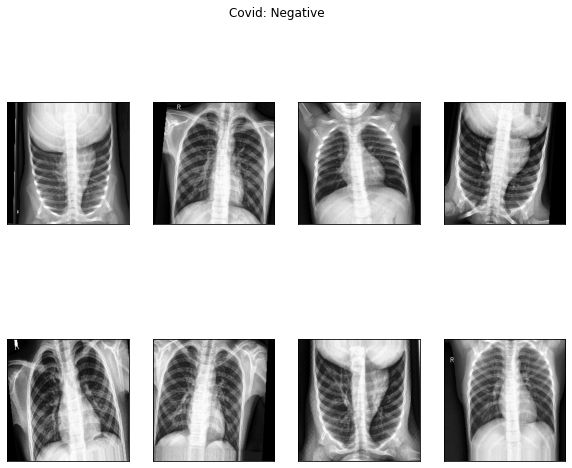

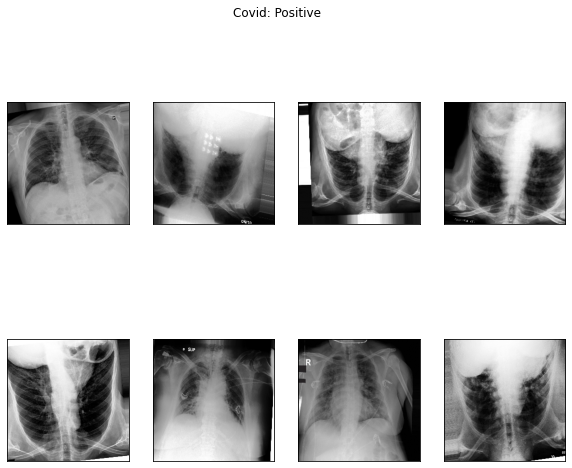

In [10]:
plot_sample_images(X, y)

In [11]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [13]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 429
number of validation examples = 92
number of test examples = 92


In [14]:
# CNN based model in keras


def build_model(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(32, (3, 3), activation = 'relu')(X_input)
    X = Conv2D(32, (3, 3), activation = 'relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Dropout(0.25)(X)
    
    X = Conv2D(64, (3, 3), activation = 'relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Dropout(0.25)(X)
    
    
    X = Conv2D(128, (3, 3), activation = 'relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Dropout(0.25)(X)

    X = Flatten()(X) 
    X = Dense(64, activation='relu')(X) 
    X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X) 
    
    model = Model(inputs = X_input, outputs = X)
    
    return model    


In [15]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 238, 238, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 236, 236, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 118, 118, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 118, 118, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 116, 116, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 64)       

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
14/14 [==============================] - 45s 3s/step - loss: 1.1600 - accuracy: 0.4872 - val_loss: 0.6925 - val_accuracy: 0.4022
Epoch 2/20
14/14 [==============================] - 45s 3s/step - loss: 0.6769 - accuracy: 0.5688 - val_loss: 0.6292 - val_accuracy: 0.8696
Epoch 3/20
14/14 [==============================] - 45s 3s/step - loss: 0.5403 - accuracy: 0.7552 - val_loss: 0.5661 - val_accuracy: 0.6848
Epoch 4/20
14/14 [==============================] - 45s 3s/step - loss: 0.4214 - accuracy: 0.8252 - val_loss: 0.3902 - val_accuracy: 0.9022
Epoch 5/20
14/14 [==============================] - 45s 3s/step - loss: 0.2693 - accuracy: 0.9021 - val_loss: 0.2631 - val_accuracy: 0.9348
Epoch 6/20
14/14 [==============================] - 45s 3s/step - loss: 0.2077 - accuracy: 0.9231 - val_loss: 0.2617 - val_accuracy: 0.9348
Epoch 7/20
14/14 [==============================] - 44s 3s/step - loss: 0.1436 - accuracy: 0.9371 - val_loss: 0.2332 - val_accuracy: 0.9348
Epoch 8/20
14/14 [==

In [17]:
history = model.history.history

In [18]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

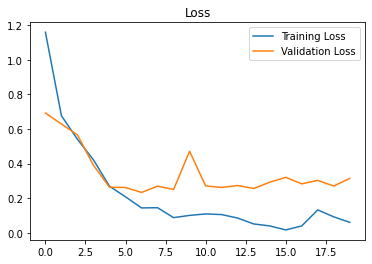

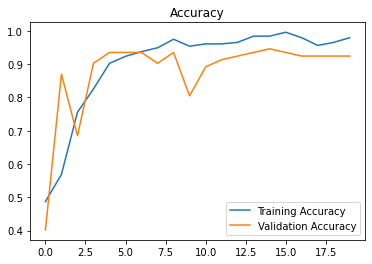

In [19]:
plot_metrics(history)

In [20]:
# CNN based model in keras


def build_model_1(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(32, (3, 3), activation = 'relu')(X_input)
    X = Conv2D(32, (3, 3), activation = 'relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Dropout(0.25)(X)
    
#     X = Conv2D(32, (3, 3), activation = 'relu')(X)
#     X = MaxPooling2D((2, 2))(X)
#     X = Dropout(0.25)(X)
    
    
#     X = Conv2D(128, (3, 3), activation = 'relu')(X)
#     X = MaxPooling2D((2, 2))(X)
#     X = Dropout(0.25)(X)

    X = Flatten()(X) 
    X = Dense(64, activation='relu')(X) 
    X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X) 
    
    model_1 = Model_1(inputs = X_input, outputs = X)
    
    return model_1    

In [21]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model_1=build_model(IMG_SHAPE)
model_1.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 238, 238, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 236, 236, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 118, 118, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 118, 118, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 116, 116, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 58, 58, 64)       

In [40]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_1.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
14/14 [==============================] - 44s 3s/step - loss: 0.6979 - accuracy: 0.5711 - val_loss: 0.6537 - val_accuracy: 0.6304
Epoch 2/20
14/14 [==============================] - 44s 3s/step - loss: 0.5909 - accuracy: 0.6970 - val_loss: 0.3544 - val_accuracy: 0.8913
Epoch 3/20
14/14 [==============================] - 45s 3s/step - loss: 0.3295 - accuracy: 0.8601 - val_loss: 0.2698 - val_accuracy: 0.8913
Epoch 4/20
14/14 [==============================] - 45s 3s/step - loss: 0.2160 - accuracy: 0.9301 - val_loss: 0.2759 - val_accuracy: 0.8913
Epoch 5/20
14/14 [==============================] - 45s 3s/step - loss: 0.2082 - accuracy: 0.9254 - val_loss: 0.2475 - val_accuracy: 0.9348
Epoch 6/20
14/14 [==============================] - 44s 3s/step - loss: 0.1473 - accuracy: 0.9394 - val_loss: 0.2232 - val_accuracy: 0.9239
Epoch 7/20
14/14 [==============================] - 44s 3s/step - loss: 0.1419 - accuracy: 0.9510 - val_loss: 0.2592 - val_accuracy: 0.9239
Epoch 8/20
14/14 [==

In [41]:
history = model_1.history.history

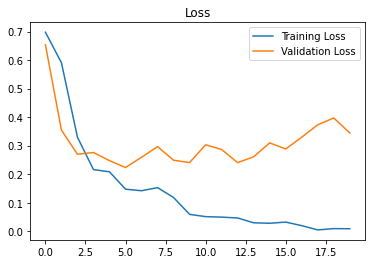

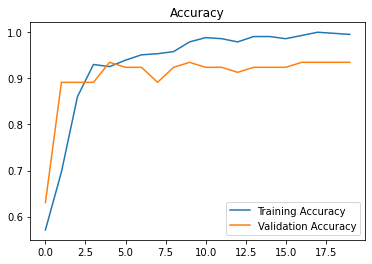

In [42]:
plot_metrics(history)

In [25]:
# CNN based model in keras


def build_model_2(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(32, (3, 3), activation = 'relu')(X_input)
    X = Conv2D(32, (3, 3), activation = 'relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Dropout(0.25)(X)
    
    X = Conv2D(64, (3, 3), activation = 'relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Dropout(0.5)(X)
    
    
#     X = Conv2D(128, (3, 3), activation = 'relu')(X)
#     X = MaxPooling2D((2, 2))(X)
#     X = Dropout(0.25)(X)

    X = Flatten()(X) 
    X = Dense(64, activation='relu')(X) 
    X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X) 
    
    model_2 = Model_2(inputs = X_input, outputs = X)
    
    return model_2    

In [30]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model_2=build_model(IMG_SHAPE)
model_2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 238, 238, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 236, 236, 32)      9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 118, 118, 32)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 118, 118, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 116, 116, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 58, 58, 64)       

In [31]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
14/14 [==============================] - 45s 3s/step - loss: 0.9162 - accuracy: 0.5315 - val_loss: 0.6841 - val_accuracy: 0.6196
Epoch 2/20
14/14 [==============================] - 45s 3s/step - loss: 0.6634 - accuracy: 0.6177 - val_loss: 0.5865 - val_accuracy: 0.8478
Epoch 3/20
14/14 [==============================] - 44s 3s/step - loss: 0.4701 - accuracy: 0.8065 - val_loss: 0.3419 - val_accuracy: 0.8804
Epoch 4/20
14/14 [==============================] - 44s 3s/step - loss: 0.3054 - accuracy: 0.8858 - val_loss: 0.2819 - val_accuracy: 0.9130
Epoch 5/20
14/14 [==============================] - 44s 3s/step - loss: 0.2159 - accuracy: 0.9254 - val_loss: 0.2300 - val_accuracy: 0.9022
Epoch 6/20
14/14 [==============================] - 44s 3s/step - loss: 0.1604 - accuracy: 0.9487 - val_loss: 0.2408 - val_accuracy: 0.9130
Epoch 7/20
14/14 [==============================] - 45s 3s/step - loss: 0.1584 - accuracy: 0.9277 - val_loss: 0.2295 - val_accuracy: 0.9239
Epoch 8/20
14/14 [==

In [38]:
history = model_2.history.history

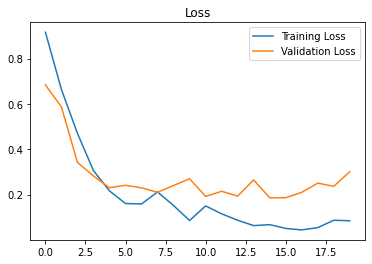

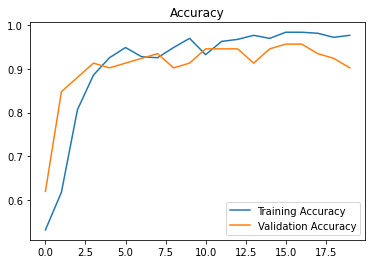

In [39]:
plot_metrics(history)